In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/df.csv')

In [2]:
#Drop columns not used for the model

df = df.drop(columns=['from_competition_competition_name', 'to_competition_competition_name', 'playerId', 'scorer_before_grouped',
                       'playerName', 'date','season', 'fee' , 'from_team', 'from_teamId', 'from_competition',
                         'to_team', 'to_teamId', 'to_competition', 'start_date', 'end_date', 'total_minutes_played', 'scorer_before_grouped_new','goals_scored_before_grouped',
                         'clean_sheets_before_grouped_new', 'scorer_before', 'from_league_cluster', 'to_league_cluster',
                           'total_games', 'total_possible_minutes', 'scorer', 'performance_ratio', 'transfer_age_grouped',
                           'total_minutes_played', 'goals_scored', 'assists', 'clean_sheets', 'success', 'success_before', 'performance_ratio_before', 'fee_to_value_ratio',
                           'minutes_per_clean_sheet', 'goals_per_minute', 'assists_per_minute', 'assists_before_grouped',  'nationality', 'joker_ratio', 'goals_per_minute_before', 'assists_per_minute_before',
                             'prev_total_minutes_played', 'prev_total_games','prev_total_possible_minutes','goals_scored_before','assists_before', 'from_competition_competition_association','to_competition_competition_association',
                               'clean_sheets_before', 'from_competition_competition_age_category','to_competition_competition_age_category', 'minutes_per_clean_sheet_before' ])

df.drop(columns=['young_player_transfer'], inplace=True)

#New variables, filling NaN values with 0

df['value_age_product'] = (df['marketvalue_closest'] * df['transferAge'])
df['value_per_age'] = (df['marketvalue_closest'] / df['transferAge'])

df['fromTeam_marketValue'] = df['fromTeam_marketValue'].fillna(0)
df['toTeam_marketValue'] = df['toTeam_marketValue'].fillna(0)



In [3]:
# Library imports
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.callbacks import VerboseCallback
import matplotlib.pyplot as plt
import seaborn as sns


data = df

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 3/5] END colsample_bytree=0.48202079177066276, gamma=2, learning_rate=0.018993019982717508, max_depth=6, min_child_weight=17, n_estimators=1083, reg_alpha=2, reg_lambda=1.6092563512856308, subsample=0.845669496655476;, score=0.296 total time=   8.6s
[CV 1/5] END colsample_bytree=0.48202079177066276, gamma=2, learning_rate=0.018993019982717508, max_depth=6, min_child_weight=17, n_estimators=1083, reg_alpha=2, reg_lambda=1.6092563512856308, subsample=0.845669496655476;, score=0.271 total time=   8.7s
[CV 4/5] END colsample_bytree=0.48202079177066276, gamma=2, learning_rate=0.018993019982717508, max_depth=6, min_child_weight=17, n_estimators=1083, reg_alpha=2, reg_lambda=1.6092563512856308, subsample=0.845669496655476;, score=0.273 total time=   8.7s
[CV 5/5] END colsample_bytree=0.48202079177066276, gamma=2, learning_rate=0.018993019982717508, max_depth=6, min_child_weight=17, n_estimators=1083, reg_alpha=2, reg_lambda=1.6092

<Figure size 1000x800 with 0 Axes>

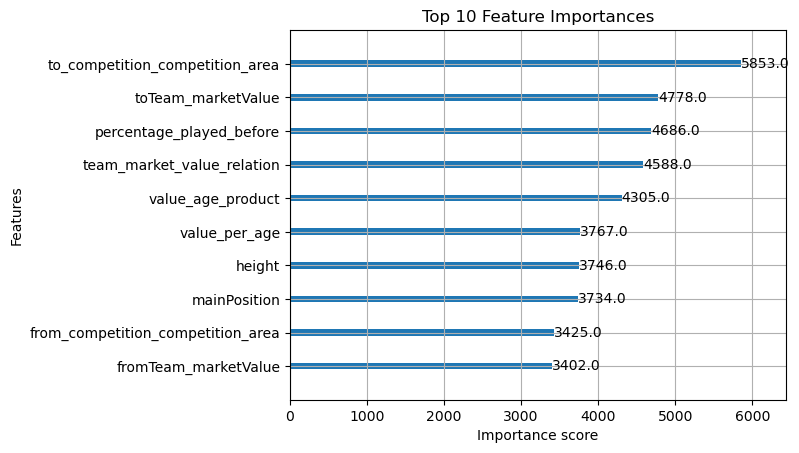

Test RMSE: 25.8942
Test R-squared: 0.2766


In [4]:
# XGBOOST MODEL

# Drop target
X = data.drop(columns=['percentage_played'])
y = data['percentage_played']

# Filter potential invalid and extreme target values
valid_idx = (~pd.isnull(y)) & (~np.isinf(y)) & (np.abs(y) < 101)
X = X[valid_idx]
y = y[valid_idx]

# Handle infinite values in numeric columns
for col in X.columns:
    if X[col].dtype.kind in 'biufc':  # numeric columns
        finite_vals = X[col][np.isfinite(X[col])]
        if not finite_vals.empty:
            max_val = finite_vals.max()
            min_val = finite_vals.min()
            X.loc[X[col] == np.inf, col] = max_val
            X.loc[X[col] == -np.inf, col] = min_val

# Handle categorical 'foot' with 'unknown'
X['foot'] = X['foot'].fillna('unknown')

# Group infrequent categories and convert object columns to categorical dtype
# Set minimum count threshold
MIN_COUNT = 500

for col in X.select_dtypes(include='object').columns:
    value_counts = X[col].value_counts()
    valid_categories = value_counts[value_counts >= MIN_COUNT].index
    X[col] = X[col].where(X[col].isin(valid_categories), 'other')
    X[col] = X[col].astype('category')  # Convert to categorical dtype here

# -------------------------------
# SPLIT DATA into Train and Test
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# -------------------------------
# Define XGBoost model with categorical variables enabled
# -------------------------------
model = XGBRegressor(
    random_state=1,
    tree_method='hist',
    enable_categorical=True
)

# -------------------------------
# Define search space of hyperparameters
# -------------------------------
search_space = {
    'n_estimators': (1000, 1200),
    'max_depth': (5, 9),
    'learning_rate': (0.005, 0.02),
    'subsample': (0.8, 0.95),
    'colsample_bytree': (0.4, 0.6),
    'gamma': (1, 2),
    'reg_alpha': (1, 3),
    'reg_lambda': (0.5, 2),
    'min_child_weight': (10, 20)
}

# -------------------------------
# Bayesian Optimization parameters
# -------------------------------
bayes_search = BayesSearchCV(
    model,
    search_space,
    n_iter=10,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=3
)

# Fit the model on training data
bayes_search.fit(X_train, y_train)
best_params = bayes_search.best_params_
print(f"Best Hyperparameters found by Bayesian Optimization: {best_params}")

# Train best model on training data
best_model = bayes_search.best_estimator_
best_model.fit(X_train, y_train)

# -------------------------------
# Plot feature importance
# -------------------------------
plt.figure(figsize=(10, 8))
plot_importance(best_model, importance_type='weight', max_num_features=10, title="Top 10 Feature Importances")
plt.show()


# -------------------------------
# Evaluate on TEST data
# -------------------------------
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")

# -------------------------------
# Save predictions
# -------------------------------
predictions_df = X_test.copy()
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_pred
predictions_df['Residual'] = predictions_df['Actual'] - predictions_df['Predicted']
predictions_df.to_csv("xgboost_predictions_test.csv", index=False)


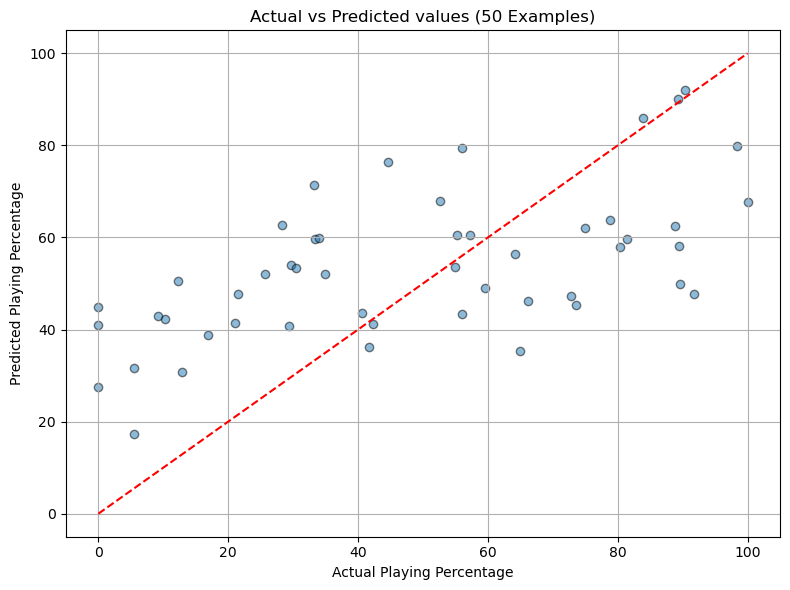

In [5]:
# Create a DataFrame with predictions and actual values
pred_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Sample 1000 random rows for visualization
sampled_pred_df = pred_df.sample(n=50, random_state=42)

# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(sampled_pred_df['Actual'], sampled_pred_df['Predicted'], alpha=0.5, edgecolor='k')
plt.plot([0, 100], [0, 100], color='red', linestyle='--')  # perfect prediction line
plt.xlabel("Actual Playing Percentage")
plt.ylabel("Predicted Playing Percentage")
plt.title("Actual vs Predicted values (50 Examples)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# Save the trained model in JSON format
best_model.save_model("model2.json")


In [7]:
# Save category mappings
import json

category_mappings = {}
for col in X.select_dtypes(include='category').columns:
    category_mappings[col] = list(X[col].cat.categories)

with open("category_mappings.json", "w") as f:
    json.dump(category_mappings, f)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data points in the train set: 42955, number of used features: 22
[LightGBM] [Info] Number of data points in the train set: 42955, number of used features: 22
[LightGBM] [Info] Start training from score 53.183436
[LightGBM] [Info] Start training from score 53.311934
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003993 seconds.
You can set `force_row_

<Figure size 1000x800 with 0 Axes>

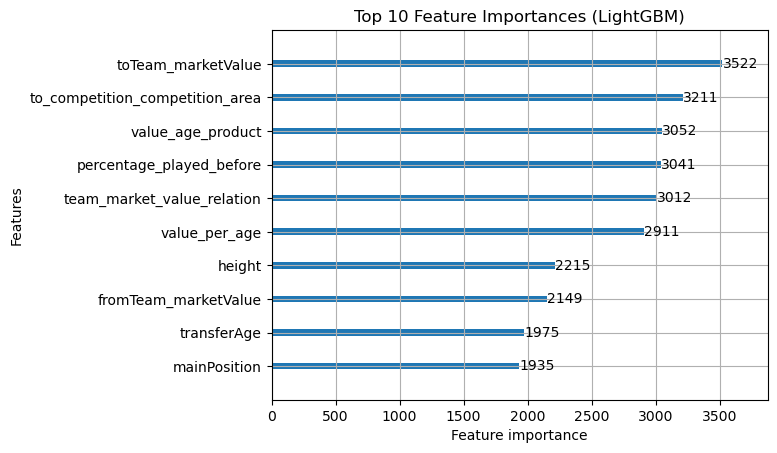

NameError: name 'X_test_filtered' is not defined

In [8]:
from lightgbm import LGBMRegressor, plot_importance
from skopt import BayesSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -------------------------------
# Define LightGBM model
# -------------------------------
model = LGBMRegressor(
    random_state=1,
    objective='regression',  # RMSE
    n_jobs=-1
)

# -------------------------------
# Define search space
# -------------------------------
search_space = {
    'n_estimators': (1000, 1200),
    'max_depth': (5, 9),
    'learning_rate': (0.005, 0.02, 'log-uniform'),
    'subsample': (0.8, 0.95),
    'colsample_bytree': (0.4, 0.6),
    'reg_alpha': (1, 3),
    'reg_lambda': (0.5, 2),
    'min_child_weight': (10, 20)
}

# -------------------------------
# Bayesian Optimization parameters
# -------------------------------
bayes_search = BayesSearchCV(
    model,
    search_space,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=3
)

# Fit using existing X_train / y_train
bayes_search.fit(X_train, y_train, categorical_feature='auto')
best_params = bayes_search.best_params_
print(f"Best Hyperparameters found by Bayesian Optimization: {best_params}")

# Train best LightGBM model on full training set
best_model_lgb = bayes_search.best_estimator_
best_model_lgb.fit(X_train, y_train, categorical_feature='auto')

# -------------------------------
# Plot Feature Importances
# -------------------------------
plt.figure(figsize=(10, 8))
plot_importance(best_model_lgb, max_num_features=10, title="Top 10 Feature Importances (LightGBM)")
plt.show()

# -------------------------------
# Evaluate on Test Set
# -------------------------------
y_pred_lgb = best_model_lgb.predict(X_test_filtered)
rmse = np.sqrt(mean_squared_error(y_test_filtered, y_pred_lgb))
r2 = r2_score(y_test_filtered, y_pred_lgb)
print(f"LightGBM Test RMSE: {rmse:.4f}")
print(f"LightGBM Test R-squared: {r2:.4f}")

# -------------------------------
# Save Predictions
# -------------------------------
predictions_df = X_test_filtered.copy()
predictions_df['Actual'] = y_test_filtered
predictions_df['Predicted'] = y_pred_lgb
predictions_df['Residual'] = predictions_df['Actual'] - predictions_df['Predicted']
predictions_df.to_csv("lightgbm_predictions_test.csv", index=False)


In [ ]:
import shap

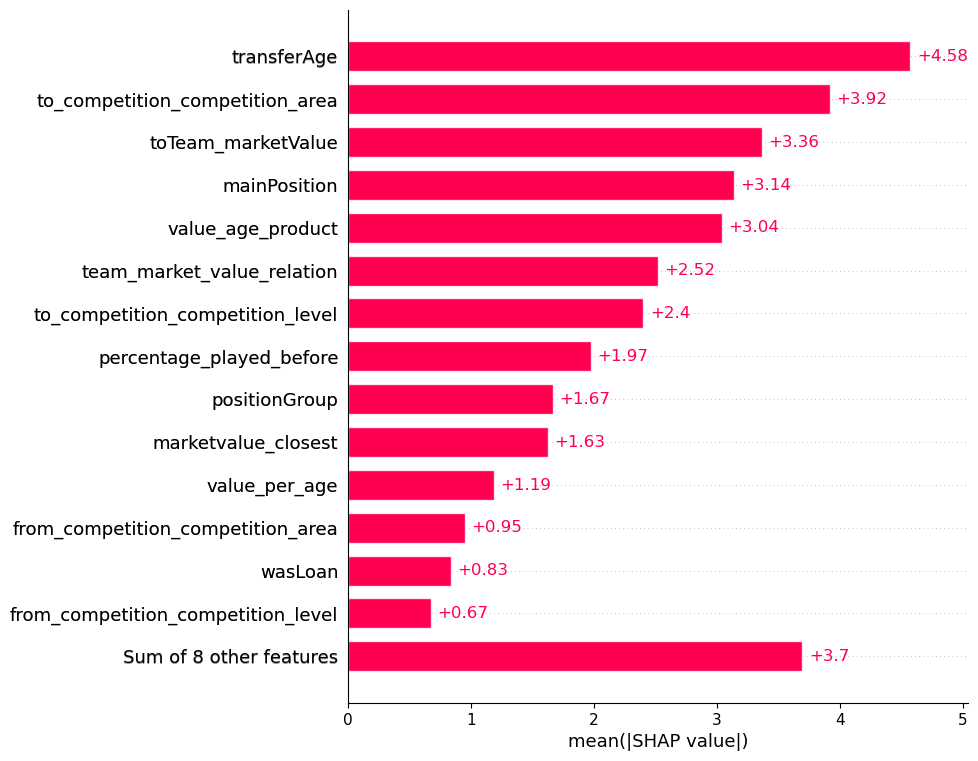

In [ ]:
from sklearn.preprocessing import LabelEncoder

X_train_encoded = X_train.copy()
X_test_encoded = X_test_filtered.copy()

for col in X_train.select_dtypes(include='category').columns:
    le = LabelEncoder()

    # Convert all values to string to avoid mixed types
    X_train_encoded[col] = X_train[col].astype(str)
    X_test_encoded[col] = X_test_filtered[col].astype(str)

    le.fit(X_train_encoded[col])
    X_train_encoded[col] = le.transform(X_train_encoded[col])
    X_test_encoded[col] = le.transform(X_test_encoded[col])


explainer = shap.Explainer(best_model_lgb)
shap_values = explainer(X_test_encoded)
shap.plots.bar(shap_values, max_display=15)



No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


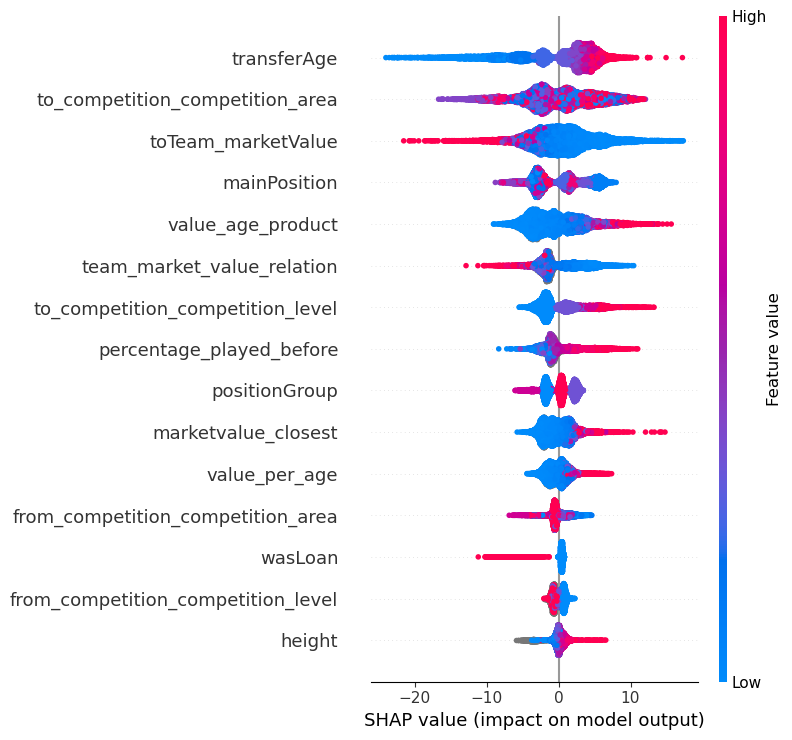

In [ ]:
shap.summary_plot(shap_values, X_test_encoded, plot_type="dot", max_display=15)


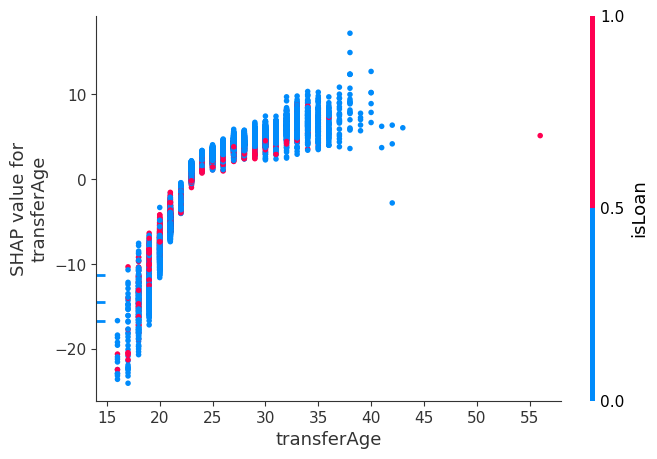

In [ ]:
import numpy as np
np.float = float  # patch deprecated np.float to builtin float

shap.dependence_plot("transferAge", shap_values.values, X_test_encoded)


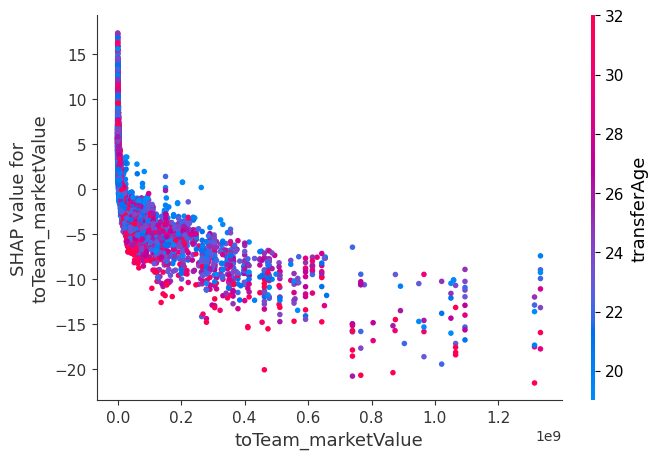

In [ ]:

shap.dependence_plot("toTeam_marketValue", shap_values.values, X_test_encoded)

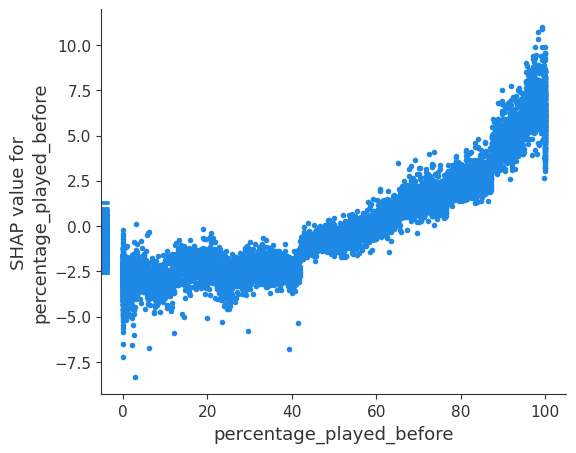

In [ ]:
shap.dependence_plot("percentage_played_before", shap_values.values, X_test_encoded, interaction_index=None)  


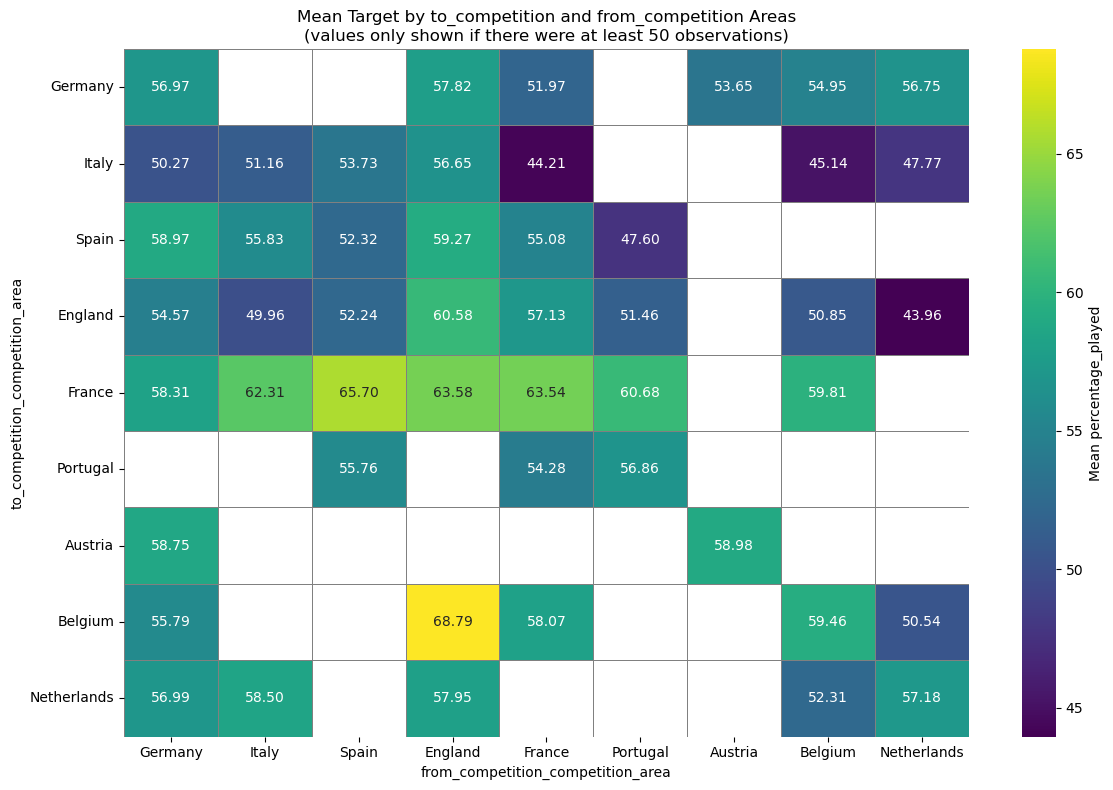

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define allowed countries
allowed_countries = ['Germany', 'Italy', 'Spain', 'England', 'France', 'Portugal', 'Austria', 'Belgium', 'Netherlands']

# Combine features and target
df_combined = pd.concat([X_train[['to_competition_competition_area', 'from_competition_competition_area']], y_train], axis=1)

# Filter for allowed countries on both sides
df_combined = df_combined[
    (df_combined['to_competition_competition_area'].isin(allowed_countries)) &
    (df_combined['from_competition_competition_area'].isin(allowed_countries))
]

# Count occurrences for each combination
counts = df_combined.groupby(['to_competition_competition_area', 'from_competition_competition_area']).size().reset_index(name='count')

# Keep combinations with at least 30 observations
valid_combinations = counts[counts['count'] >= 40][['to_competition_competition_area', 'from_competition_competition_area']]

# Filter to keep only valid rows
df_filtered = df_combined.merge(valid_combinations, on=['to_competition_competition_area', 'from_competition_competition_area'], how='inner')

# Calculate mean target for filtered combinations
pivot_table = df_filtered.groupby(['to_competition_competition_area', 'from_competition_competition_area'])[y_train.name].mean().unstack()

# Reindex rows and columns to ensure all allowed countries appear
pivot_table = pivot_table.reindex(index=allowed_countries, columns=allowed_countries)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".2f",
    cmap='viridis',
    cbar_kws={'label': f'Mean {y_train.name}'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title('Mean Target by to_competition and from_competition Areas\n(values only shown if there were at least 50 observations)')
plt.xlabel('from_competition_competition_area')
plt.ylabel('to_competition_competition_area')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, s
from sklearn.metrics import r2_score

# 1) Filter test set
mask = ~X_test['toTeam_marketValue'].isna()
X_test_filtered = X_test[mask]
y_test_filtered = y_test[mask]

# 2) Predict on train set using only XGBoost
train_preds_xgb = best_model.predict(X_train)

# 3) Prepare train DataFrame for meta-model
train_meta_df = pd.DataFrame({
    'Predicted_xgb': train_preds_xgb,
    'Actual': y_train.values if hasattr(y_train, 'values') else y_train
})

X_meta_train = train_meta_df[['Predicted_xgb']].values
y_meta_train = train_meta_df['Actual'].values

# 4) Fit GAM meta-model with only XGBoost predictions
gam = LinearGAM(s(0)).fit(X_meta_train, y_meta_train)

# 5) Predict on filtered test set using only XGBoost
test_preds_xgb_filtered = best_model.predict(X_test_filtered)

# 6) Prepare meta features for filtered test set
X_meta_test_filtered = test_preds_xgb_filtered.reshape(-1, 1)
y_meta_test_filtered = y_test_filtered.values if hasattr(y_test_filtered, 'values') else y_test_filtered

# 7) Predict with GAM meta-model on filtered test predictions
meta_preds_test_filtered = gam.predict(X_meta_test_filtered)

# 8) Evaluate GAM meta-model performance
r2_meta = r2_score(y_meta_test_filtered, meta_preds_test_filtered)
print(f"R-squared after GAM meta-model on filtered test set (XGBoost only): {r2_meta:.4f}")


R-squared after GAM meta-model on filtered test set (XGBoost only): 0.2636


In [ ]:
import joblib

# Save the GAM model
joblib.dump(gam, "gam_meta_model.pkl")


['gam_meta_model.pkl']

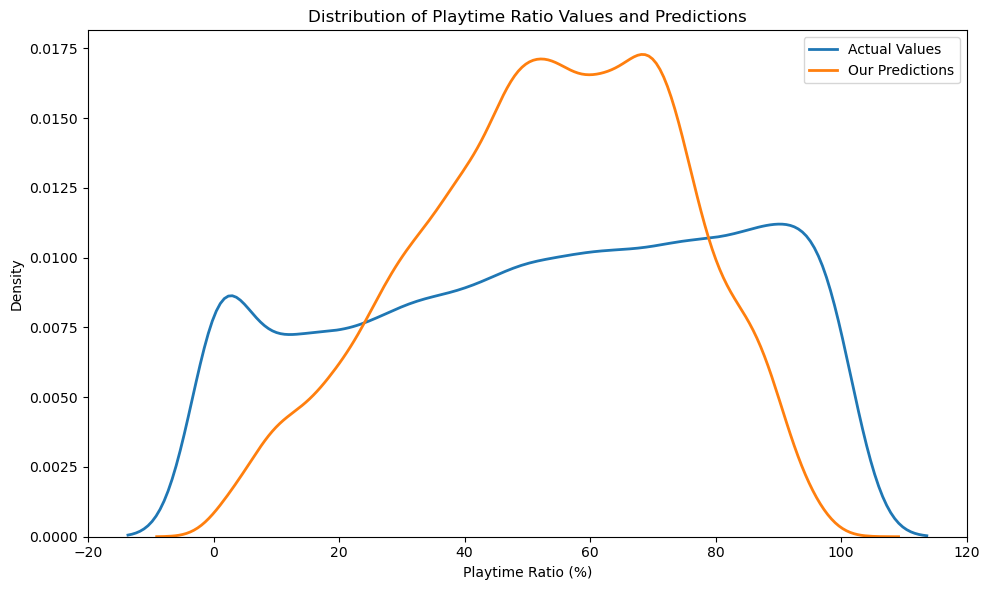

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# KDE plots
sns.kdeplot(y_test_filtered, label='Actual Values', linewidth=2)
sns.kdeplot(meta_preds_test_filtered, label='Our Predictions', linewidth=2)

# Labels and layout
plt.title('Distribution of Playtime Ratio Values and Predictions')
plt.xlabel('Playtime Ratio (%)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# 1️⃣  Make a copy for preprocessing
X_for_pred = df.drop(columns=['percentage_played']).copy()

# Same preprocessing
MIN_COUNT = 500

for col in X_for_pred.columns:
    if X_for_pred[col].dtype.kind in 'biufc':
        finite_vals = X_for_pred[col][np.isfinite(X_for_pred[col])]
        if not finite_vals.empty:
            max_val = finite_vals.max()
            min_val = finite_vals.min()
            X_for_pred.loc[X_for_pred[col] == np.inf, col] = max_val
            X_for_pred.loc[X_for_pred[col] == -np.inf, col] = min_val

X_for_pred['foot'] = X_for_pred['foot'].fillna('unknown')

for col in X_for_pred.select_dtypes(include='object').columns:
    value_counts = X_for_pred[col].value_counts()
    valid_categories = value_counts[value_counts >= MIN_COUNT].index
    X_for_pred[col] = X_for_pred[col].where(X_for_pred[col].isin(valid_categories), 'other')
    X_for_pred[col] = X_for_pred[col].astype('category')

# 2️⃣  Predict
preds = best_model.predict(X_for_pred)

# 3️⃣  Attach to the **original df**
df_with_preds = df.copy()
df_with_preds['Predicted_percentage_played'] = preds

# ✅  Now you have the raw df + prediction
print(df_with_preds.head())

# Optional: save it
df_with_preds.to_csv('df_with_xgb_prediction.csv', index=False)


   height     mainPosition positionGroup   foot  transferAge  isLoan  wasLoan  \
0   188.0       goalkeeper    goalkeeper  right         38.0   False    False   
1   191.0       goalkeeper    goalkeeper  right         39.0   False    False   
2   182.0        rightback      defender  right         35.0   False    False   
3   176.0    centerforward      attacker  right         35.0   False    False   
4   175.0  centralmidfield    midfielder  right         37.0   False    False   

   marketvalue_closest  fee_to_value_ratio  foreign_transfer  ...  \
0         1.000000e-07                 NaN                 0  ...   
1         2.000000e-07                 NaN                 1  ...   
2         1.500000e-06                 NaN                 1  ...   
3         4.500000e-06                 NaN                 0  ...   
4         1.500000e-06                 NaN                 0  ...   

  scorer_before_grouped_new  clean_sheets_before_grouped  \
0                       NaN           

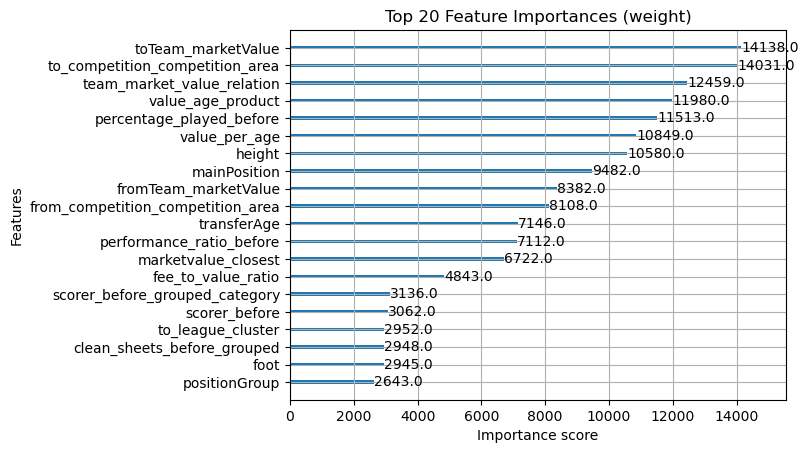

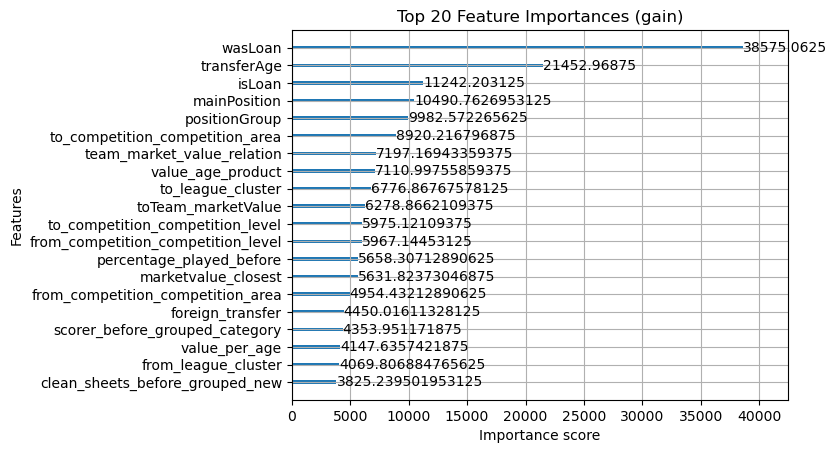

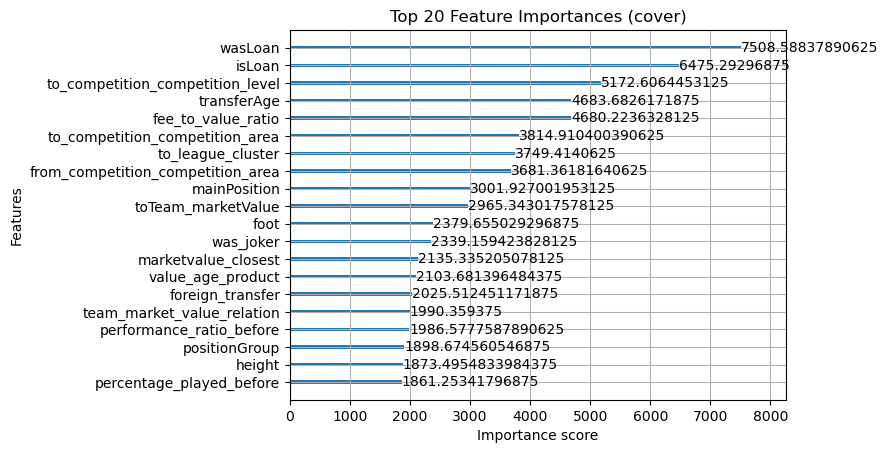

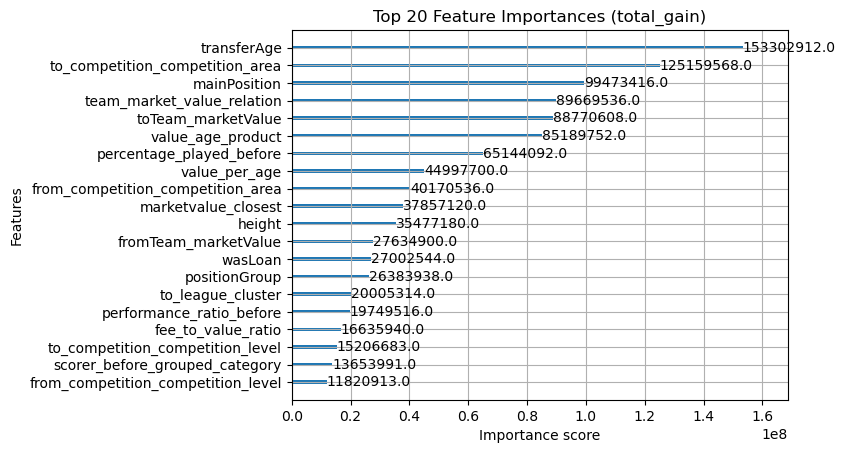

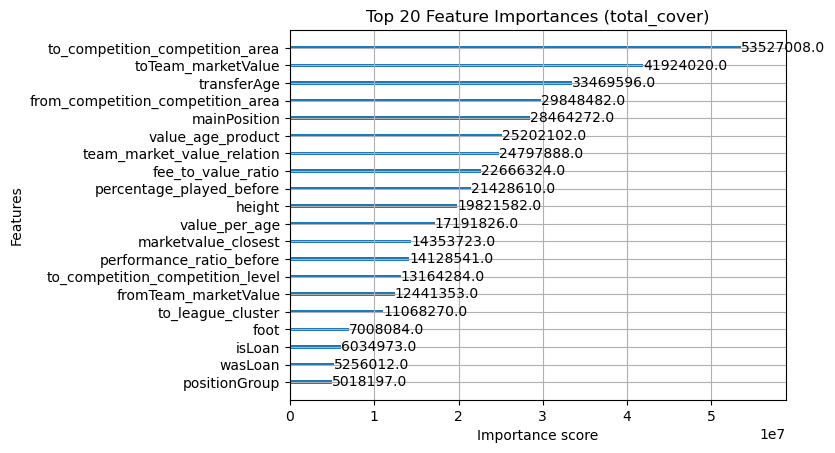

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for imp_type in importance_types:
    xgb.plot_importance(best_model, importance_type=imp_type, max_num_features=20, title=f"Top 20 Feature Importances ({imp_type})")
    plt.show()

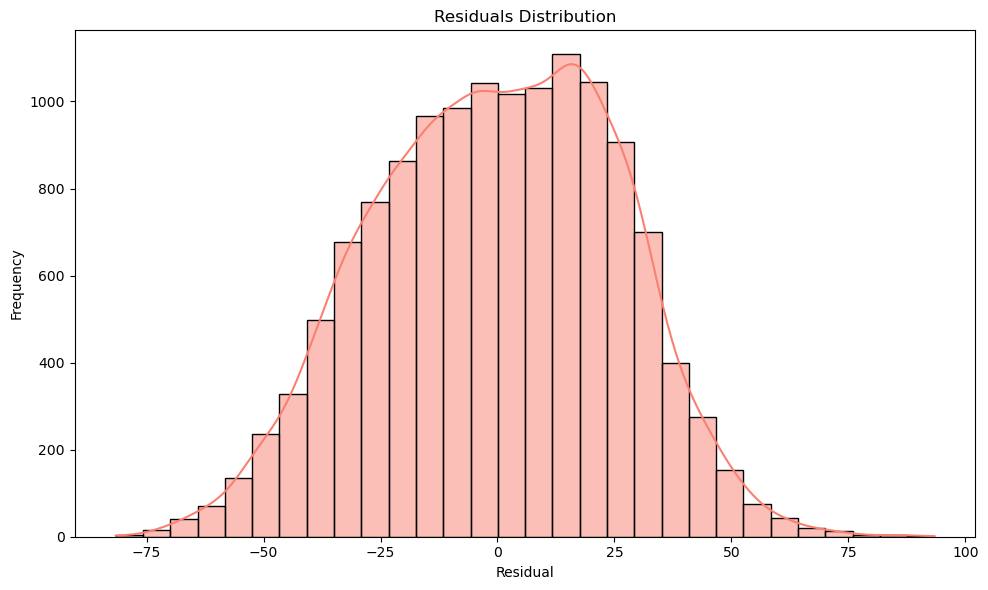

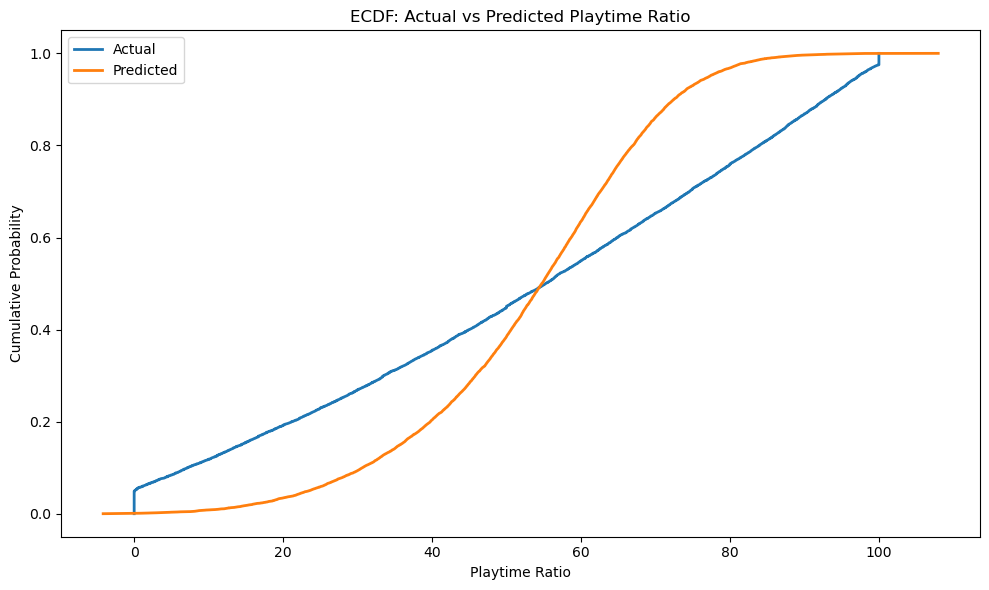

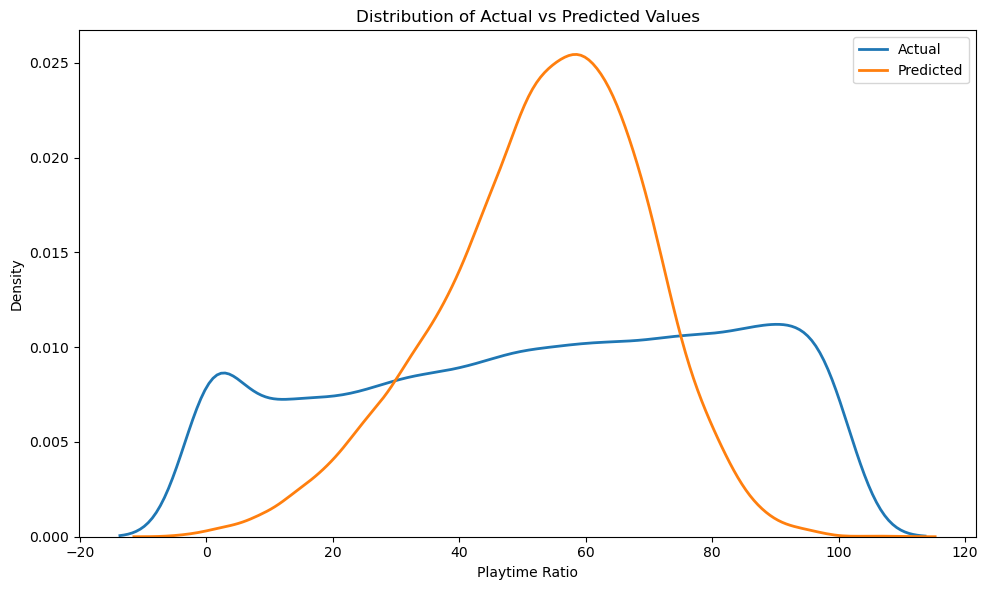

In [ ]:
# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='salmon')
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# ECDF Comparison
from statsmodels.distributions.empirical_distribution import ECDF

ecdf_actual = ECDF(y_test)
ecdf_pred = ECDF(y_pred)

plt.figure(figsize=(10, 6))
plt.plot(ecdf_actual.x, ecdf_actual.y, label='Actual', lw=2)
plt.plot(ecdf_pred.x, ecdf_pred.y, label='Predicted', lw=2)
plt.title('ECDF: Actual vs Predicted Playtime Ratio')
plt.xlabel('Playtime Ratio')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.tight_layout()
plt.show()

# KDE Comparison
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='Actual', linewidth=2)
sns.kdeplot(y_pred, label='Predicted', linewidth=2)
plt.title('Distribution of Actual vs Predicted Values')
plt.xlabel('Playtime Ratio')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()
